# Pyspark TensorFlow Inference

## Image classification
Based on: https://www.tensorflow.org/tutorials/keras/save_and_load

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import tensorflow as tf

from tensorflow import keras

print(tf.version.VERSION)

### Load and preprocess dataset

In [ ]:
# load dataset as numpy arrays
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape, test_images.shape

In [ ]:
# flatten and normalize
train_images = train_images.reshape(-1, 784) / 255.0
test_images = test_images.reshape(-1, 784) / 255.0

In [ ]:
train_images.shape, test_images.shape

### Define a model

In [ ]:
# Define a simple sequential model
def create_model():
    model = tf.keras.models.Sequential([
        keras.layers.Dense(512, activation='relu', input_shape=(784,)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10)
    ])

    model.compile(optimizer='adam',
                    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[tf.metrics.SparseCategoricalAccuracy()])

    return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

### Train model

In [ ]:
model.fit(train_images, 
          train_labels,  
          epochs=5,
          validation_data=(test_images, test_labels))

In [ ]:
test_img = test_images[:1]
model.predict(test_img)

In [ ]:
plt.figure()
plt.imshow(test_img.reshape(28,28))
plt.show()

### Save Model

In [ ]:
subprocess.call("rm -rf mnist_model".split())

In [ ]:
model.save('mnist_model')

### Inspect saved model

In [ ]:
subprocess.call("tree mnist_model".split())

In [ ]:
subprocess.call("saved_model_cli show --dir mnist_model --tag_set serve --signature_def serving_default".split())

### Load model

In [ ]:
new_model = tf.keras.models.load_model('mnist_model')
new_model.summary()

In [ ]:
new_model.inputs

### Predict

In [ ]:
new_model.predict(test_images[:1])

## PySpark

In [ ]:
import pandas as pd

# from pyspark.sql.functions import col, pandas_udf, PandasUDFType
# from pyspark.sql.types import *

### Convert numpy array to Spark DataFrame (via Pandas DataFrame)

In [ ]:
# numpy array to pandas DataFrame
test_pdf = pd.DataFrame(test_images)
test_pdf.shape

In [ ]:
%%time
# 784 columns of float
df = spark.createDataFrame(test_pdf)

In [ ]:
%%time
# 1 column of array<float>
test_pdf['data'] = test_pdf.values.tolist()
pdf = test_pdf[['data']]
pdf.shape

In [ ]:
%%time
df = spark.createDataFrame(pdf).repartition(10)

### Save the test dataset as parquet files

In [ ]:
df.write.mode("overwrite").parquet("mnist_test")

### Check arrow memory configuration

In [ ]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "128")
# This line will fail if the vectorized reader runs out of memory
assert len(df.head()) > 0, "`df` should not be empty" 

## Inference using Spark ML Model
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [ ]:
import sparkext

In [ ]:
df = spark.read.parquet("mnist_test")

In [ ]:
model = sparkext.tensorflow.Model("mnist_model") \
            .setInputCol("data") \
            .setOutputCol("preds")

In [ ]:
predictions = model.transform(df)

In [ ]:
predictions.write.mode("overwrite").parquet("mnist_predictions")

### Check predictions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
%%time
preds = predictions.collect()

In [ ]:
preds[0].preds

In [ ]:
img = preds[0].data
img = np.array(img).reshape(28,28)

In [ ]:
plt.figure()
plt.imshow(img)
plt.show()

## Inference using Spark DL UDF
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [ ]:
from pyspark.sql.functions import col

In [ ]:
df = spark.read.parquet("mnist_test")

In [ ]:
df.schema

In [ ]:
from sparkext.tensorflow import model_udf

In [ ]:
mnist = model_udf("mnist_model", batch_size=500)

In [ ]:
%%time
preds = df.withColumn("preds", mnist(col("data"))).collect()

## Inference using Triton UDF
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [ ]:
from pyspark.sql.functions import col

In [ ]:
df = spark.read.parquet("mnist_test")

In [ ]:
df.schema

In [ ]:
from sparkext.triton.udf import model_udf

In [ ]:
mnist = model_udf("localhost:8001", "mnist_model", batch_size=4)

In [ ]:
%%time
preds = df.withColumn("preds", mnist(col("data"))).collect()

### Check predictions

In [ ]:
preds[0].preds

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
img = preds[0].data
img = np.array(img).reshape(28,28)

In [ ]:
plt.figure()
plt.imshow(img)
plt.show()

## Inference using MLFlow Spark UDF

### Save as MLFlow Model
Manual signature (with input names).  This is currently the only working solution, since inferred signatures do not work.

In [ ]:
import mlflow
import numpy as np
import subprocess
import tensorflow as tf

In [ ]:
from mlflow.models.signature import infer_signature, ModelSignature
from mlflow.types.schema import Schema, TensorSpec

In [ ]:
model = tf.keras.models.load_model("mnist_model")

In [ ]:
input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 784), "dense_input")])
output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 10), "dense_1")])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)
signature

In [ ]:
subprocess.call("rm -rf mnist_mlflow_manual".split())
mlflow.tensorflow.save_model(tf_saved_model_dir="mnist_model", 
                             tf_meta_graph_tags=["serve"], 
                             tf_signature_def_key="serving_default",
                             signature=signature,
                             conda_env="conda.yml",
                             path="mnist_mlflow_manual")

### Using (modified) mlflow.pyfunc.spark_udf

In [ ]:
import mlflow
from pyspark.sql.functions import struct, col
from pyspark.sql.types import *

In [ ]:
df = spark.read.parquet("mnist_test")
df = df.withColumn('dense_input',df['data'].cast("array<float>"))

In [ ]:
df.schema

In [ ]:
# mnist = mlflow.pyfunc.spark_udf(spark, model_uri="mnist_mlflow_manual", result_type="array<float>")
mnist = mlflow.pyfunc.spark_udf(spark, model_uri="mnist_mlflow_manual", result_type="array<float>", env_manager="conda")

In [ ]:
mnist.metadata.signature

In [ ]:
%%time
preds = df.withColumn("preds", mnist(col("dense_input"))).collect()

In [ ]:
import time

t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)

In [ ]:
%%time
preds = df.withColumn("preds", mnist(col("dense_input"))).collect()

In [ ]:
%%time
preds = df.withColumn("preds", mnist(col("dense_input"))).collect()

In [ ]:
%%time
preds = df.withColumn("preds", mnist(col("dense_input"))).collect()

## Inference using Spark DL API

### 1 column of 784 float

In [ ]:
import numpy as np

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [ ]:
df = spark.read.parquet("mnist_test")
len(df.columns)

In [ ]:
def predict_batch_fn():
    import tensorflow as tf
    model = tf.keras.models.load_model('/home/leey/devpub/leewyang/sparkext/examples/tensorflow/mnist_model')
    def predict(inputs: Union[np.array, Dict[str, np.array]]) -> Union[np.array, Dict[str, np.array]]:
        return model.predict(inputs)
        
    return predict

In [ ]:
mnist = predict_batch_udf(predict_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=8192,
                          input_tensor_shapes=[[-1, 784]])

In [ ]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

In [ ]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

In [ ]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

In [ ]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

#### Check predictions

In [ ]:
preds = df.withColumn("preds", mnist(struct(df.columns))).limit(10).toPandas()
preds

In [ ]:
sample = preds.iloc[0]
predictions = sample.preds
img = sample.data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
img = np.array(img).reshape(28,28)

In [ ]:
plt.figure()
plt.imshow(img)
plt.show()

In [ ]:
predictions

### 784 columns of float

In [ ]:
from pyspark.sql.functions import array

In [ ]:
df = spark.read.parquet("mnist_784")
len(df.columns)

In [ ]:
from pyspark.sql.functions import array

# preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

In [ ]:
%%time
preds = df.withColumn("preds", mnist(struct(*df.columns))).collect()

In [ ]:
%%time
preds = df.withColumn("preds", mnist(struct(*df.columns))).collect()

In [ ]:
%%time
preds = df.withColumn("preds", mnist(struct(*df.columns))).collect()

In [ ]:
%%time
preds = df.withColumn("preds", mnist(struct(*df.columns))).collect()

### Check prediction

In [ ]:
preds = df.withColumn("preds", mnist(struct(df.columns))).limit(10).toPandas()
preds

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
sample = preds.iloc[0]
predictions = sample.preds
img = sample.drop('preds').to_numpy(dtype=float)

In [ ]:
img = np.array(img).reshape(28,28)

In [ ]:
plt.figure()
plt.imshow(img)
plt.show()

In [ ]:
predictions

### Using Triton Server
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [ ]:
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import col, struct
from pyspark.sql.types import ArrayType, FloatType

#### Start Triton Server on each executor

In [10]:
num_executors = 1

nodeRDD = sc.parallelize(list(range(num_executors)), num_executors)

def start_triton(it):
    import docker
    import time
    import tritonclient.grpc as grpcclient
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    if containers:
        print(">>>> containers: {}".format([c.short_id for c in containers]))
    else:
        container=client.containers.run(
            "nvcr.io/nvidia/tritonserver:22.07-py3", "tritonserver --model-repository=/models",
            detach=True,
            device_requests=[docker.types.DeviceRequest(device_ids=["0"], capabilities=[['gpu']])],
            name="spark-triton",
            network_mode="host",
            remove=True,
            shm_size="64M",
            volumes={"/home/leey/devpub/leewyang/sparkext/examples/models": {"bind": "/models", "mode": "ro"}}
        )
        print(">>>> starting triton: {}".format(container.short_id))

        # wait for triton to be running
        time.sleep(15)
        client = grpcclient.InferenceServerClient("localhost:8001")
        ready = False
        while not ready:
            try:
                ready = client.is_server_ready()
            except Exception as e:
                time.sleep(5)
            
    return [True]

nodeRDD.mapPartitions(start_triton).collect()

[True]

In [11]:
df = spark.read.parquet("mnist_test")

In [12]:
df.schema

StructType([StructField('data', ArrayType(DoubleType(), True), True)])

In [13]:
def predict_batch_fn():
    import numpy as np
    import tritonclient.grpc as grpcclient
    client = grpcclient.InferenceServerClient("localhost:8001")
    def predict(inputs):
        request = [grpcclient.InferInput("dense_input", inputs.shape, "FP32")]
        request[0].set_data_from_numpy(inputs.astype(np.float32))
        response = client.infer("mnist_model", inputs=request)
        return response.as_numpy("dense_1")
    return predict

In [14]:
mnist = predict_batch_udf(predict_batch_fn,
                        input_tensor_shapes=[[-1, 784]],
                        return_type=ArrayType(FloatType()),
                        batch_size=8192)

In [15]:
%%time
preds = df.withColumn("preds", mnist(struct("data"))).collect()

CPU times: user 513 ms, sys: 130 ms, total: 643 ms
Wall time: 2.92 s


In [16]:
%%time
preds = df.withColumn("preds", mnist(struct("data"))).collect()

CPU times: user 695 ms, sys: 121 ms, total: 816 ms
Wall time: 1.61 s


In [17]:
%%time
preds = df.withColumn("preds", mnist(struct("data"))).collect()

CPU times: user 483 ms, sys: 88 ms, total: 571 ms
Wall time: 1.38 s


In [18]:
%%time
preds = df.withColumn("preds", mnist(struct("data"))).collect()

CPU times: user 525 ms, sys: 107 ms, total: 632 ms
Wall time: 1.41 s


#### Check predictions

In [19]:
preds = df.withColumn("preds", mnist(struct(df.columns))).limit(10).toPandas()
preds

,data,preds
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-15.634783744812012, 7.199462413787842, -3.78..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.653353691101074, -4.47070837020874, -0.989..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6.980148792266846, -13.740118026733398, -6.2..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-21.266935348510742, -23.427534103393555, -9...."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6.042927265167236, -5.73275089263916, 13.566..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-9.103192329406738, -5.535467147827148, -11.7..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-17.69834327697754, -3.888951539993286, 2.432..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.1577810049057007, -18.7540225982666, -6.03..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.5018510818481445, -18.89392852783203, -6.1..."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-9.909956932067871, -14.437578201293945, -1.5..."


In [20]:
import matplotlib.pyplot as plt
import numpy as np

In [21]:
sample = preds.iloc[0]
predictions = sample.preds
img = sample.data

In [22]:
img = np.array(img).reshape(28,28)

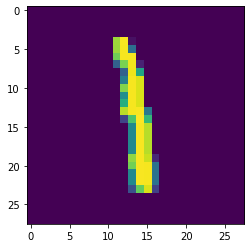

In [23]:
plt.figure()
plt.imshow(img)
plt.show()

In [24]:
predictions

[-15.634783744812012,
 7.199462413787842,
 -3.7822794914245605,
 -0.8188831210136414,
 -2.81819748878479,
 -6.400604248046875,
 -8.396441459655762,
 -3.6724092960357666,
 -1.2260267734527588,
 -6.031836986541748]

### Generic Triton function

In [25]:
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import col, struct
from pyspark.sql.types import ArrayType, FloatType

In [26]:
df = spark.read.parquet("mnist_test")

In [27]:
def triton_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient
    
    np_types = {
      "BOOL": np.dtype(np.bool8),
      "INT8": np.dtype(np.int8),
      "INT16": np.dtype(np.int16),
      "INT32": np.dtype(np.int32),
      "INT64": np.dtype(np.int64),
      "FP16": np.dtype(np.float16),
      "FP32": np.dtype(np.float32),
      "FP64": np.dtype(np.float64),
      "FP64": np.dtype(np.double),
      "BYTES": np.dtype(object)
    }

    client = grpcclient.InferenceServerClient(triton_uri)
    model_meta = client.get_model_metadata(model_name)
    
    def predict(inputs):
        if isinstance(inputs, np.ndarray):
            # single ndarray input
            request = [grpcclient.InferInput(model_meta.inputs[0].name, inputs.shape, model_meta.inputs[0].datatype)]
            request[0].set_data_from_numpy(inputs.astype(np_types[model_meta.inputs[0].datatype]))
        else:
            # dict of multiple ndarray inputs
            request = [grpcclient.InferInput(i.name, inputs[i.name].shape, i.datatype) for i in model_meta.inputs]
            for i in request:
                i.set_data_from_numpy(inputs[i.name].astype(np_types[i.datatype]))
        
        response = client.infer(model_name, inputs=request)
        return response.as_numpy(model_meta.outputs[0].name)     # TODO: multiple outputs
        
    return predict

In [28]:
predict = predict_batch_udf(triton_fn,
                          input_tensor_shapes=[[-1, 784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=8192,
                          triton_uri="localhost:8001",
                          model_name="mnist_model")

In [29]:
%%time
preds = df.withColumn("preds", predict(struct("data"))).collect()

CPU times: user 434 ms, sys: 74.3 ms, total: 509 ms
Wall time: 1.8 s


In [30]:
%%time
preds = df.withColumn("preds", predict(struct("data"))).collect()

CPU times: user 644 ms, sys: 67.1 ms, total: 711 ms
Wall time: 1.38 s


In [31]:
%%time
preds = df.withColumn("preds", predict(struct("data"))).collect()

CPU times: user 488 ms, sys: 101 ms, total: 589 ms
Wall time: 1.3 s


In [32]:
%%time
preds = df.withColumn("preds", predict(struct("data"))).collect()

CPU times: user 704 ms, sys: 63.8 ms, total: 768 ms
Wall time: 1.42 s


#### Stop Triton Server on each executor

In [33]:
def stop_triton(it):
    import docker
    import time
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    print(">>>> stopping containers: {}".format([c.short_id for c in containers]))
    if containers:
        container=containers[0]
        container.stop(timeout=120)

    return [True]

nodeRDD.mapPartitions(stop_triton).collect()

[True]

In [34]:
spark.stop()

Traceback (most recent call last):
  File "/home/leey/.pyenv/versions/3.9.10/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/leey/.pyenv/versions/3.9.10/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/leey/.pyenv/versions/3.9.10/envs/spark_dev/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/leey/.pyenv/versions/3.9.10/envs/spark_dev/lib/python3.9/site-packages/traitlets/config/application.py", line 976, in launch_instance
    app.start()
  File "/home/leey/.pyenv/versions/3.9.10/envs/spark_dev/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/home/leey/.pyenv/versions/3.9.10/envs/spark_dev/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/home/leey/.pyenv/versions/3.9.10/lib/python3